In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import glob

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
module_path = os.path.join(os.environ['HOME'],'tools')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.helper_functions import calc_wind
import mmctools.plotting as mplt

# update units set to conform to BLM style, e.g., [m s^-1] instead of [m/s]
mplt.standard_fieldlabels = mplt.fieldlabels_superscript_units
mplt.standard_spectrumlabels = mplt.spectrumlabels_superscript_units

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# Plot Tendency Figures
Written by [Caroline Draxl](mailto:Caroline.Draxl@nrel.gov)

In [6]:
wrfdatapath = '/projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro'

Output folder to store figures

In [7]:
figuredir = 'Figures'

if not os.path.isdir(figuredir):
    os.makedirs(figuredir)

## Load WRF data

In [8]:
%%time
datasets = {}
for i, L in enumerate([0,6000,24000]):
    for w in [0,60,120,180]:
        dpath = os.path.join(
            wrfdatapath,
            'L{:d}'.format(L),
            'SWIFT_w{:d}_L{:d}.nc'.format(w,L),
        )
        simname = 'L'+str(3**(i+1))+'_T'+str(w)
        print(simname, dpath)
        
        # Load data
        ds = xr.open_dataset(dpath)
        # Round timestamps to 10min (artefact from Javier's scripts)
        newtimes = ds.time.dt.round('10min')
        # Note difference in datetime conversion of matplotlib.dates.num2date and netCDF4.num2date
        # The former is used in old scripts of Javier, so here we correct for the difference manually
        newtimes += pd.to_timedelta(1,unit='day')
        ds = ds.assign_coords(time=newtimes)
        # Convert to pandas
        df = ds.sel(site=0).to_dataframe()
        # Rename indices
        df.index.rename(['datetime','height'], inplace=True)
        # Rename column
        df.rename(columns={'U':'u','V':'v','W':'w','Th':'theta'}, inplace=True)
        # Convert from K/s to K/h
        df['theta_adv'] = df['Thadv'] * 3600.0
        # Compute Spg
        df['Spg'], df['Dpg'] = calc_wind(df,u='Ug',v='Vg')
        df['Sadv'], df['Dadv'] = calc_wind(df,u='Uadv',v='Vadv')
        
        datasets[simname] = df

L3_T0 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L0/SWIFT_w0_L0.nc
L3_T60 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L0/SWIFT_w60_L0.nc
L3_T120 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L0/SWIFT_w120_L0.nc
L3_T180 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L0/SWIFT_w180_L0.nc
L9_T0 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L6000/SWIFT_w0_L6000.nc
L9_T60 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L6000/SWIFT_w60_L6000.nc
L9_T120 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L6000/SWIFT_w120_L6000.nc
L9_T180 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L6000/SWIFT_w180_L6000.nc
L27_T0 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L24000/SWIFT_w0_L24000.nc
L27_T60 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L24000/SWIFT_w60_L24000.nc
L27_T120 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L24000/SWIFT_w120_L24000.nc
L27_T180 /projects/mmc/SWIFTRegion/8Nov2013/WRF_Rerun_Caro/L24000/SWIFT_w180_L24000.nc
CPU times: user 685 ms

In [9]:
datasets['L3_T0'].head()

lat        lon        fc         u         v  \
datetime   height                                                      
2013-11-08 0.0     33.61054 -102.05054  0.000081  0.000000  0.000000   
           5.0     33.61054 -102.05054  0.000081  0.479062  4.959677   
           10.0    33.61054 -102.05054  0.000081  0.486861  5.031047   
           15.0    33.61054 -102.05054  0.000081  0.502189  5.164141   
           20.0    33.61054 -102.05054  0.000081  0.510388  5.252008   

                          w       theta  Utend  Vtend   Ug  ...         TSK  \
datetime   height                                           ...               
2013-11-08 0.0     0.000000  282.552106    0.0    0.0  0.0  ...  282.552106   
           5.0     0.006206  292.452065    0.0    0.0  0.0  ...  282.552106   
           10.0    0.006197  292.509405    0.0    0.0  0.0  ...  282.552106   
           15.0    0.006189  292.638344    0.0    0.0  0.0  ...  282.552106   
           20.0    0.006181  292.728605    0.0    0.0  0.0  ...  282.552106   

                    wt   LH          Psfc    L  theta_adv  Spg    Dpg  Sadv  \
datetime   height                                                             
2013-11-08 0.0     0.0  0.0  91154.734405 -inf        0.0  0.0  180.0   0.0   
           5.0     0.0  0.0  91154.734405 -inf        0.0  0.0  180.0   0.0   
           10.0    0.0  0.0  91154.734405 -inf        0.0  0.0  180.0   0.0   
           15.0    0.0  0.0  91154.734405 -inf        0.0  0.0  180.0   0.0   
           20.0    0.0  0.0  91154.734405 -inf        0.0  0.0  180.0   0.0   

                    Dadv  
datetime   height         
2013-11-08 0.0     180.0  
           5.0     180.0  
           10.0    180.0  
           15.0    180.0  
           20.0    180.0  

[5 rows x 30 columns]

In [10]:
datasets['L3_T0'].columns

Index(['lat', 'lon', 'fc', 'u', 'v', 'w', 'theta', 'Utend', 'Vtend', 'Ug',
       'Vg', 'Uadv', 'Vadv', 'Ucor', 'Vcor', 'Uphys', 'Vphys', 'Thadv', 'ust',
       'T2', 'TSK', 'wt', 'LH', 'Psfc', 'L', 'theta_adv', 'Spg', 'Dpg', 'Sadv',
       'Dadv'],
      dtype='object')

In [11]:
datasets['L3_T0'].index.get_level_values(0).unique()

DatetimeIndex(['2013-11-08 00:00:00', '2013-11-08 00:10:00',
               '2013-11-08 00:20:00', '2013-11-08 00:30:00',
               '2013-11-08 00:40:00', '2013-11-08 00:50:00',
               '2013-11-08 01:00:00', '2013-11-08 01:10:00',
               '2013-11-08 01:20:00', '2013-11-08 01:30:00',
               ...
               '2013-11-09 22:30:00', '2013-11-09 22:40:00',
               '2013-11-09 22:50:00', '2013-11-09 23:00:00',
               '2013-11-09 23:10:00', '2013-11-09 23:20:00',
               '2013-11-09 23:30:00', '2013-11-09 23:40:00',
               '2013-11-09 23:50:00', '2013-11-10 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=289, freq=None)

## Plot temperature field, tendency and advection (Figure 6)

In [12]:
df = datasets['L3_T0']

In [13]:
# Compute theta_tend as time derivative of theta
unstacked = df.unstack()
datetime = unstacked.index.get_level_values(0).values
times = (datetime - datetime[0])/pd.to_timedelta('1s')
theta_tend = np.gradient(unstacked['theta'].values, times, axis=0)
df['theta_tend'] = theta_tend.ravel()
# Convert from K/s to K/h
df['theta_tend'] = 3600 * df['theta_tend']

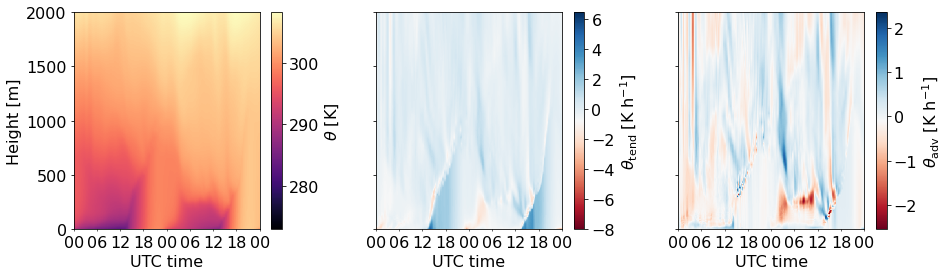

In [14]:
fig,ax,cbar = mplt.plot_timeheight(
    df,
    fields=['theta','theta_tend','theta_adv'],
    fieldlimits={'theta_tend':(-8,6.5)}, # clean up colorbar a bit
    colorschemes={'theta':'magma','theta_tend':'RdBu','theta_adv':'RdBu'},
    fieldlabels={'theta':r'$\theta$ [K]',
                 'theta_tend':r'$\theta_\mathrm{tend}$ [K h$^{-1}$]',
                 'theta_adv':r'$\theta_\mathrm{adv}$ [K h$^{-1}$]'},
    subfigsize=(5,4), ncols=3,
    timelimits=('2013-11-08 00:00:00','2013-11-10 00:00:00'),
)
ax[0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=6))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax[0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

# Clean up colorbar
cbar[1].set_ticks(np.arange(-8,7,2))

# Hide date on local time axis (BLM edits)
for axi in ax:
    axi.set_xticks([])
fig.subplots_adjust(wspace=0.3) # incr horizontal space a bit

#Save figure
figname = 'time_height_theta'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')

## Plot all pressure gradients (Figure 11)

CPU times: user 9.56 s, sys: 108 ms, total: 9.67 s
Wall time: 9.72 s


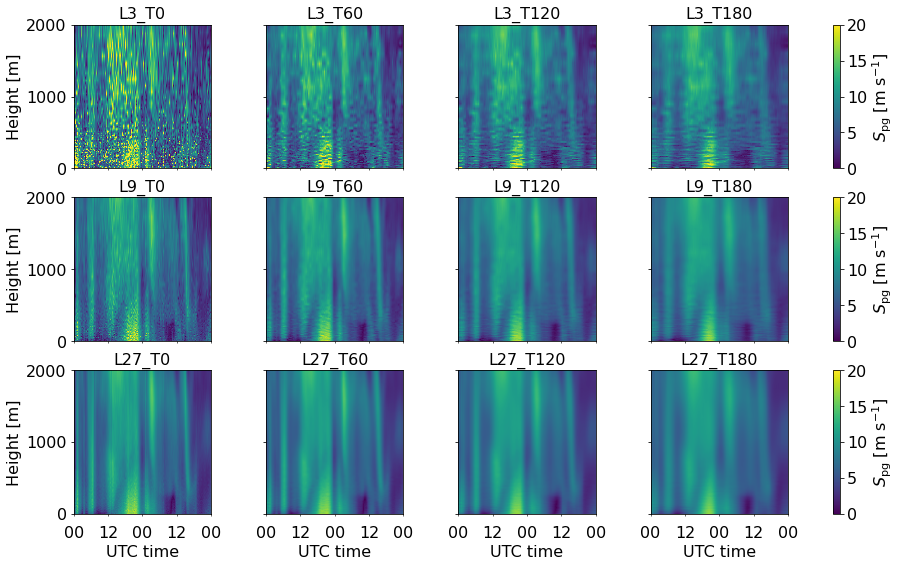

In [15]:
%%time
fig,ax, cbar = mplt.plot_timeheight(
    datasets,
    fields='Spg',   #Spg, Sadv
    fieldlimits=(0,20),
    timelimits=('2013-11-08 00:00:00','2013-11-10 00:00:00'),
    ncols=4,
    showcolorbars=False,
    subfigsize=(4,3),
    rasterized=True
)
fig.subplots_adjust(wspace=0.4)
# Adjust xaxis tick locations
ax[0,0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=12))
ax[0,0].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax[0,0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

cbar = plt.colorbar(ax[0,0].collections[-1],ax=ax[0,:])
cbar.set_label(r'$S_{\mathrm{pg}}$ [m s$^{-1}$]')
cbar = plt.colorbar(ax[1,0].collections[-1],ax=ax[1,:])
cbar.set_label(r'$S_{\mathrm{pg}}$ [m s$^{-1}$]')
cbar = plt.colorbar(ax[2,0].collections[-1],ax=ax[2,:])
cbar.set_label(r'$S_{\mathrm{pg}}$ [m s$^{-1}$]')

for axi in np.asarray(ax[-1,:]).ravel():
    axi.tick_params(axis='x', which='minor', pad=10)
    axi.tick_params(axis='x', which='major', pad=10)
    axi.set_xticks([]) # Hide date on local time axis (BLM edits)

#Save figure
figname = 'Spg_all'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')

CPU times: user 9.6 s, sys: 57.8 ms, total: 9.66 s
Wall time: 9.73 s


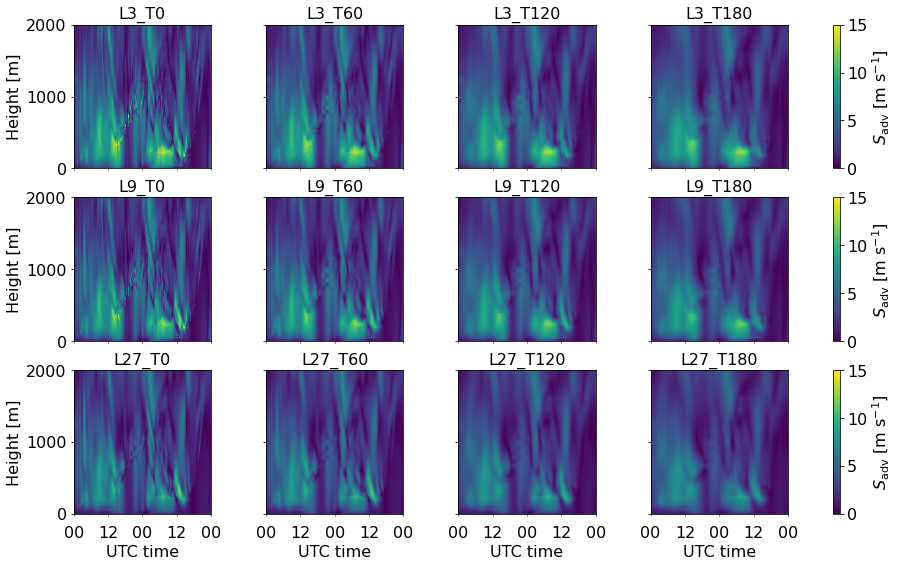

In [16]:
%%time
fig,ax, cbar = mplt.plot_timeheight(
    datasets,
    fields='Sadv',   #Spg, Sadv
    fieldlimits=(0,15),
    timelimits=('2013-11-08 00:00:00','2013-11-10 00:00:00'),
    ncols=4,
    showcolorbars=False,
    subfigsize=(4,3),
    rasterized=True
)
fig.subplots_adjust(wspace=0.4)
# Adjust xaxis tick locations
ax[0,0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=12))
ax[0,0].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax[0,0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

cbar = plt.colorbar(ax[0,0].collections[-1],ax=ax[0,:])
cbar.set_label(r'$S_{\mathrm{adv}}$ [m s$^{-1}$]')
cbar = plt.colorbar(ax[1,0].collections[-1],ax=ax[1,:])
cbar.set_label(r'$S_{\mathrm{adv}}$ [m s$^{-1}$]')
cbar = plt.colorbar(ax[2,0].collections[-1],ax=ax[2,:])
cbar.set_label(r'$S_{\mathrm{adv}}$ [m s$^{-1}$]')

for axi in np.asarray(ax[-1,:]).ravel():
    axi.tick_params(axis='x', which='minor', pad=10)
    axi.tick_params(axis='x', which='major', pad=10)
    axi.set_xticks([]) # Hide date on local time axis (BLM edits)

#Save figure
figname = 'Sadv_all'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')